# Temporary Notebook for developing new Data prep Process


In [1]:
from collections import defaultdict

import pandas as pd
from shapely.geometry import Polygon


In [2]:
# Local functions and classes
from types_and_classes import *
from utilities import *
from contours import *
#from debug_tools import *
from debug_tools import make_sphere
#from structure_slice import *
#from structure_set import *
#from relations import *


### Global Settings

In [3]:
PRECISION = 2

In [4]:
%matplotlib inline

## Relationship Tests by Relationship Type

### Color Coding
<table style="border: 2px solid black; width=50px;"><tr><td>
<ul style="font-weight: 900; font-size: 20px;">
<li style="color: blue;">region a</li>
<li style="color: green;">region b</li>
<li style="color: orange;">intersection of a & b</li></ul>
</tr></td></>

## Contains

<link rel="stylesheet" href="relations.css">
<table width="350px">
<tr class="l"><th>Contains</th><th>Transitive</th></tr>
<td class="d" colspan="2">
All points of <span class="b">b</span> lie in the interior of <span class="a">a</span>, no points of <span class="b">b</span> lie in the exterior of <span class="a">a</span>, some points in <span class="a">a</span> are exterior to <span class="b">b</span>, and the boundaries of <span class="a">a</span> and <span class="b">b</span> do not intersect.
</td></tr>
<tr><td colspan="2">
<img src="Images/Relationships/contains simple.png" alt="Contains">
<img src="Images/Relationships/contains with hole.png" alt="Contains With Hole">
</td></tr>
</table></td></tr></table>

### Contains

#### Embedded Spheres
![Embedded Spheres](<Images/FreeCAD Images/Embedded Spheres.png>)

In [5]:
slice_spacing = 0.5
# Body structure defines slices in use
sphere6 = make_sphere(roi_num=1, radius=3, spacing=slice_spacing)
sphere3 = make_sphere(roi_num=2, radius=1.5, spacing=slice_spacing)
# combine the contours
slice_data = sphere6 + sphere3


In [6]:
slice_spacing = 0.5
body = make_sphere(roi_num=0, radius=3, spacing=slice_spacing)
left_sphere = make_sphere(roi_num=1, radius=2, offset_x=-2.5, offset_z=0,
                          spacing=slice_spacing)
right_sphere = make_sphere(roi_num=1, radius=2, offset_x=2.5, offset_z=0,
                           spacing=slice_spacing)
right_middle_sphere = make_sphere(roi_num=2, radius=1, offset_x=2.5, offset_z=0,
                                  spacing=slice_spacing)
# combine the contours
slice_data = left_sphere + right_sphere + right_middle_sphere + body


### Convert contour points to polygons and sort them by area


In [7]:
contour_table, slice_sequence = build_contour_table(slice_data)

In [8]:
roi = 1

### Create identify contours that are holes and build a graph of the contours

In [9]:
contour_graph, contour_lookup = build_contour_graph(contour_table, slice_sequence, roi)

#### Create an graph of the contours for the ROI

**Find Contour Neighbours**

- For each Node in the ROI-specific Contour Graph, *starting with the first SliceIndex*:

1. Use the SliceSequence to obtain the Next SliceIndex.
2. Find all Contour nodes of the same hole type *(IsHole True or IsHole False)* with that Next SliceIndex.
3. If the Hulls of the two polygons overlap:
    > 1. Create an edge between the two Contour nodes
    > 2. Set a contourMatch attribute to the edge with the two Contour nodes as values.
    > 3. Set the Thickness of the edge to the difference between the two SliceIndexes.

4. For each Node in the ROI-specific ContourGraph calculate a Thickness from its edges.

**Contour Boundaries**
1. Select all Contour nodes in the ContourGraph with only one edge (degree=1)
2. For each of these nodes:
    1. Generate an interpolated boundary Contour 
        > - The contour is located half way between the boundary contour slice 
            and the neighbour slice that is not linked with an edge.
        > - set IsInterpolated to True
        > - set IsBoundary is True
        > - set IsHole matches the IsHole value of the non-interpolated Contour 
    1. Add the interpolated SliceIndex to SliceSequence:
        > - set 'Original' = False
        > - If the boundary contour SliceIndex  < the interpolated SliceIndex 
            >> - set 'PreviousSlice' = boundary contour SliceIndex, 
            >> - set NextSlice'= None
        > - Else:
            >> - set 'NextSlice'= boundary contour SliceIndex, 
            >> - set 'PreviousSlice '= None
    1. Add the interpolated contour to the contour graph .
    1. Add a ContourMatch edge between the original boundary contour and the interpolated contour.

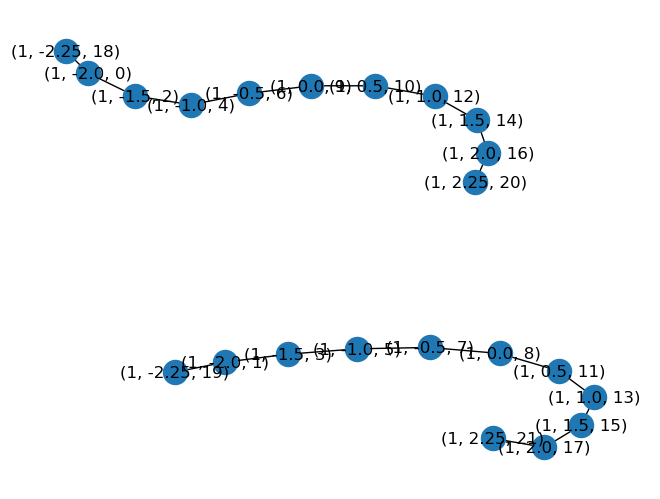

In [10]:
nx.draw(contour_graph, with_labels=True)

**EnclosedRegionGraph**
- SubGraph of ContourGraph
- Identified as all nodes in ContourGraph that have a path between them
- Has a unique RegionIndex


**EnclosedRegions**
1. Create an EnclosedRegion SubGraph for each collection of nodes in the ContourGraph that are connected by a path.
2. For each EnclosedRegion:
    1. Create a new EnclosedRegionLabel.
    2. For each Contour node in the EnclosedRegion.
        1. Set Contour.RegionIndex to the EnclosedRegionLabel.
        2. Increment and Identify and label continuous contour regions.
        
**Note:** *Changes to the Contour nodes must reflect in the nodes of the ContourGraph*


In [13]:
# Build EnclosedRegion SubGraphs and assign RegionIndex
enclosed_regions = build_enclosed_regions(contour_graph)
print(f"Number of enclosed regions: {len(enclosed_regions)}")
for idx, region in enclosed_regions.items():
    print(f"Region {idx} contains {len(region.nodes)} contours.")

Number of enclosed regions: 2
Region 1A contains 11 contours.
Region 1B contains 11 contours.


In [16]:
contour_graph.nodes[(1, -2.0, 0)]['contour'].region_index

'1A'

**Open (External) Holes**
1. For each EnclosedRegion that is a hole:
    1. Select its boundary contours.
    2. Check whether there is a non-hole contour on the next slice that completely contains the hole boundary.
    3. If any hole boundary does not have a non-hole contour on the next slice that completely contains that hole boundary, then the hole is ***Open*** (external).
    4. If all hole boundaries have a non-hole contour on the next slice that completely contains that hole boundary, then the hole is ***Closed*** (internal).
